In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sktime

from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.fbprophet import Prophet
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.sarimax import SARIMAX
from sktime.performance_metrics.forecasting import  MeanAbsolutePercentageError
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.utils.plotting import plot_series
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [6]:
# Средняя Абсолютная ошибка в процентном выражении
# Эту метрику мы будем 
# использовать для качества предсказаний временной серии
smape = MeanAbsolutePercentageError(symmetric = True)

In [7]:
# Данные взяты отсюда: https://drive.google.com/drive/folders/1vu97LRYkdzCnEgzd_X2L3KcmyZFQjtMv?usp=sharing
# Для получения данных: dvc pull -r origin
# Колонку `utc_timestamp` используем как индекс, предварительно удалив временную зону.
data_path = './data'
df = pd.read_csv(f'{data_path}/time_series_60min_singleindex.csv', parse_dates=['utc_timestamp'], index_col='utc_timestamp')
df = df.fillna(df.mean(numeric_only=True))
df.index = df.index.tz_localize(None)
df = df[['AT_load_actual_entsoe_transparency']]
df.head()

,AT_load_actual_entsoe_transparency
utc_timestamp,
2014-12-31 23:00:00,7070.148631
2015-01-01 00:00:00,5946.000000
2015-01-01 01:00:00,5726.000000
2015-01-01 02:00:00,5347.000000
2015-01-01 03:00:00,5249.000000


In [8]:
# Подготовка данных (y_train, y_test)
y = df['AT_load_actual_entsoe_transparency'].asfreq('7d')
TEST_SIZE = int(0.45 * y.size)
y_train, y_test = temporal_train_test_split(y, test_size=TEST_SIZE)
print(f'Check splitted data size: Train: {y_train.shape}, Test: {y_test.shape}')


Check splitted data size: Train: (166,), Test: (135,)


(array([-40.,   0.,  40.,  80., 120., 160., 200., 240., 280., 320.]),
 [Text(-40.0, 0, ''),
  Text(0.0, 0, '2014-12-31 23:00:00'),
  Text(40.0, 0, '2015-10-07 23:00:00'),
  Text(80.0, 0, '2016-07-13 23:00:00'),
  Text(120.0, 0, '2017-04-19 23:00:00'),
  Text(160.0, 0, '2018-01-24 23:00:00'),
  Text(200.0, 0, '2018-10-31 23:00:00'),
  Text(240.0, 0, '2019-08-07 23:00:00'),
  Text(280.0, 0, '2020-05-13 23:00:00'),
  Text(320.0, 0, '')])

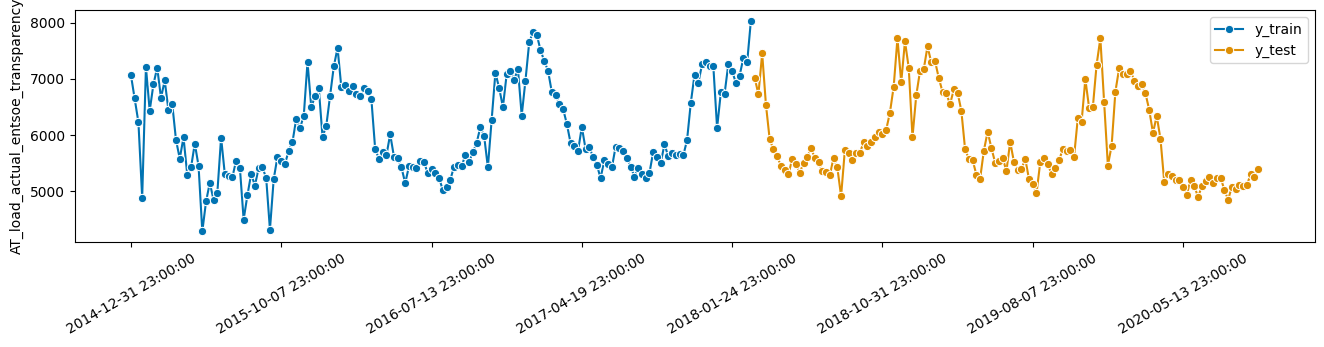

In [9]:
# Сначала отобразим данные, разбитые на тренировочную и тестовую выборки
fig, ax = plot_series(y_train, y_test, labels=['y_train', 'y_test'])
fig.subplots_adjust(bottom=0.3)
plt.xticks(rotation=30)


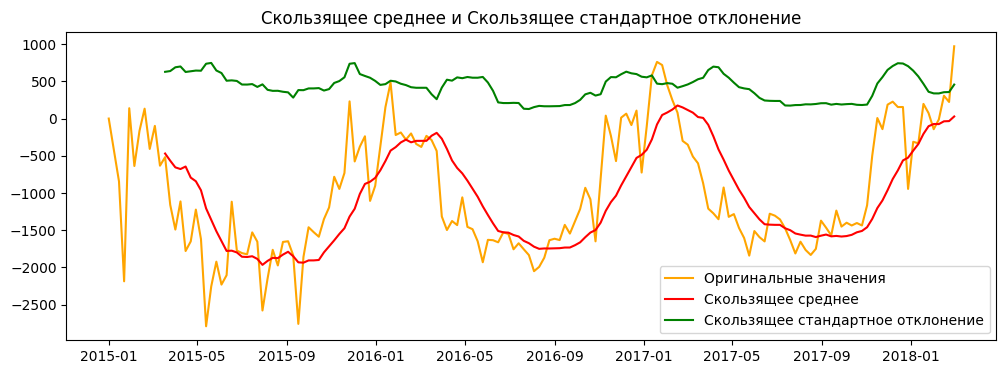

In [10]:
displayed_y = y_train

def plot_mean_and_std_deviation(y):
  ''' Отображает на графике временную серию, скользящее среднее и скользящее стандартное отклонение '''
  rolling_mean = y.rolling(window = 12).mean()
  rolling_std = y.rolling(window = 12).std()

  plt.figure(figsize=(12,4), dpi=100)

  plt.plot(y - y[0], color = 'orange', label = 'Оригинальные значения')
  plt.plot(rolling_mean - y[0], color = 'red', label = 'Скользящее среднее')
  plt.plot(rolling_std, color = 'green', label = 'Скользящее стандартное отклонение')

  plt.legend(loc = 'best')
  plt.title('Скользящее среднее и Скользящее стандартное отклонение')

# На графике - тренировочная выборка
plot_mean_and_std_deviation(displayed_y)

In [11]:
# Проверим гипотезу на нестационарность ряда:
P_THRESHOLD = 0.05 # Уровень значимости
def check_ADF(y, p_threshold = P_THRESHOLD):
  ''' Проверка статистической гипотезы на стационарность ряда '''
  result = adfuller(y)
  adf_value = result[0]
  p_value = result[1]
  print('ADF Statistic: {:.4f}'.format(adf_value))
  print('p-value: {:.4f}'.format(p_value))
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t{}: {:.4f}, {}'.format(key, value, 'outperformed' if adf_value > value else ""))    

  print(f'{p_value=}, {p_threshold=}')
  print(f'Result: The series is {"not " if p_value < p_threshold else ""}stationary')
  return result

check_ADF(displayed_y, p_threshold = P_THRESHOLD)

ADF Statistic: -1.9461
p-value: 0.3107
Critical Values:
	1%: -3.4711, outperformed
	5%: -2.8794, outperformed
	10%: -2.5763, outperformed
p_value=0.3107051371527915, p_threshold=0.05
Result: The series is stationary


(-1.9460765324938945,
 0.3107051371527915,
 2,
 163,
 {'1%': -3.471118535474365,
  '5%': -2.8794405060097024,
  '10%': -2.576313761526591},
 2219.694303021319)

В данном случае оказалось, что ряд (y_train) стационарен

ADF Statistic: -11.8916
p-value: 0.0000
Critical Values:
	1%: -3.4711, 
	5%: -2.8794, 
	10%: -2.5763, 
p_value=5.852187329206734e-22, p_threshold=0.05
Result: The series is not stationary


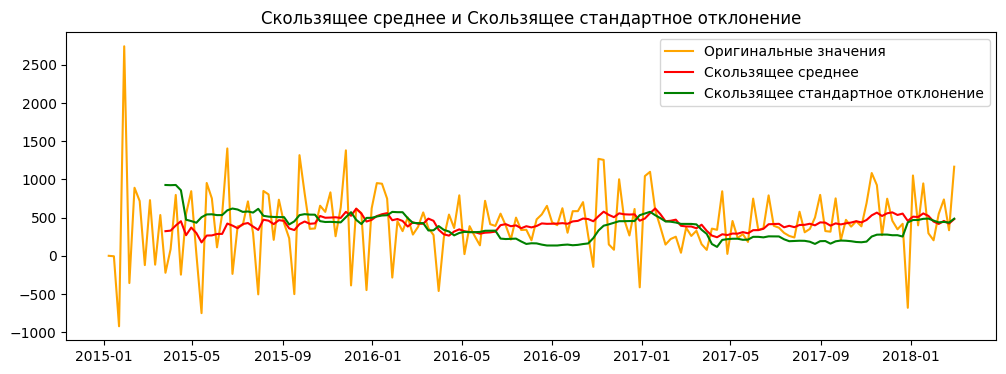

In [12]:
# Выполним дифференцирование
y_diff = displayed_y[:].diff(1).dropna()

plot_mean_and_std_deviation(y_diff)

result = check_ADF(y_diff)

In [13]:
# Проверим гипотезу на стационарность продифференцированного ряда:
result = check_ADF(y_diff)

ADF Statistic: -11.8916
p-value: 0.0000
Critical Values:
	1%: -3.4711, 
	5%: -2.8794, 
	10%: -2.5763, 
p_value=5.852187329206734e-22, p_threshold=0.05
Result: The series is not stationary


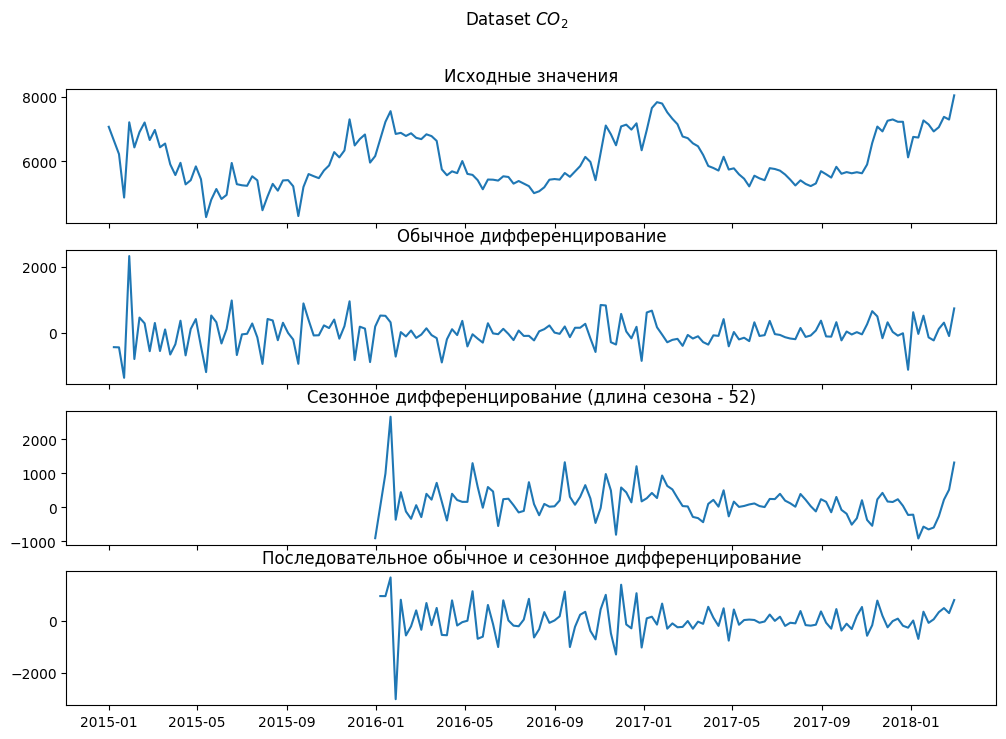

In [15]:
SEASON = 52

# Plot
fig, axes = plt.subplots(4, 1, figsize=(12, 8), dpi=100, sharex=True)

# Исходные значения
axes[0].plot(displayed_y[:])
axes[0].set_title('Исходные значения')

# Обычное дифференцирование (вычитаем предыдущее значение ряда из текущего)
axes[1].plot(displayed_y[:].diff(1))
axes[1].set_title('Обычное дифференцирование')

# Сезонное дифференцирование (вычитаем значение, отстоящее на сезон от текущего)
axes[2].plot(displayed_y[:].diff(SEASON))
axes[2].set_title(f'Сезонное дифференцирование (длина сезона - {SEASON})')

# Последовательное дифференцирование (Обычное и сезонное)
axes[3].plot(displayed_y[:].diff(1).diff(SEASON))
axes[3].set_title('Последовательное обычное и сезонное дифференцирование')

plt.suptitle('Dataset $CO_2$', fontsize=12)
plt.show()


In [16]:
# Проверим гипотезу на стационарность для ряда, последовательно дифференцированного дважды
# с обычным и сезонным лагом.
y_sdif = displayed_y[:].diff(1).diff(SEASON).dropna()
results = check_ADF(y_sdif)

ADF Statistic: -4.7521
p-value: 0.0001
Critical Values:
	1%: -3.4955, 
	5%: -2.8900, 
	10%: -2.5820, 
p_value=6.709460939284892e-05, p_threshold=0.05
Result: The series is not stationary


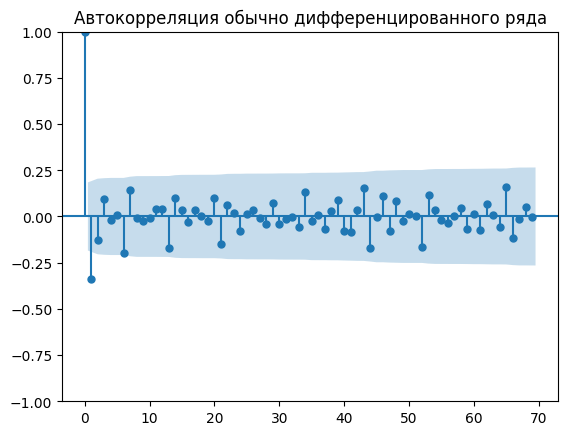

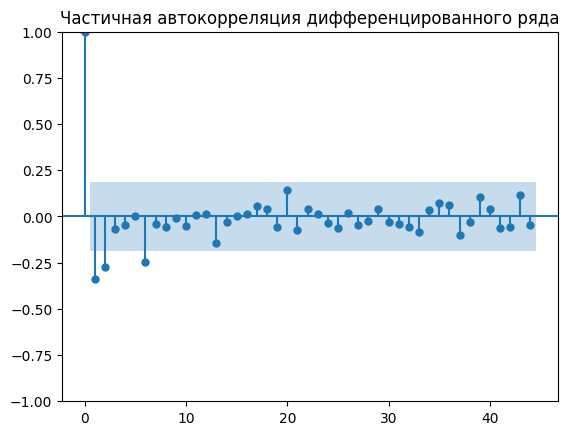

In [17]:
# Обычное дифференцирование
plot_acf(y_sdif, title='Автокорреляция обычно дифференцированного ряда', lags=np.arange(70) );plt.show()
# Обычное дифференцирование
plot_pacf(y_sdif, title='Частичная автокорреляция дифференцированного ряда', method='ywm', lags=np.arange(45))
plt.show()

In [18]:
# Применим модель SARIMAX 
forecaster = SARIMAX(order=(3, 1, 0), seasonal_order=(0, 1, 1, 52))
forecaster.fit(y_train)
print(forecaster.summary())

/home/slon/.asdf/installs/python/3.10.7/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.21980D+00    |proj g|=  1.99983D-01

At iterate    5    f=  5.16359D+00    |proj g|=  6.97797D-04

At iterate   10    f=  5.16358D+00    |proj g|=  1.20533D-03

At iterate   15    f=  5.16314D+00    |proj g|=  1.60643D-02

At iterate   20    f=  5.16119D+00    |proj g|=  7.43445D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     26      1     0     0   1.635D-05   5.161D+00
  F =   5.1611931318143549     

CONVERG

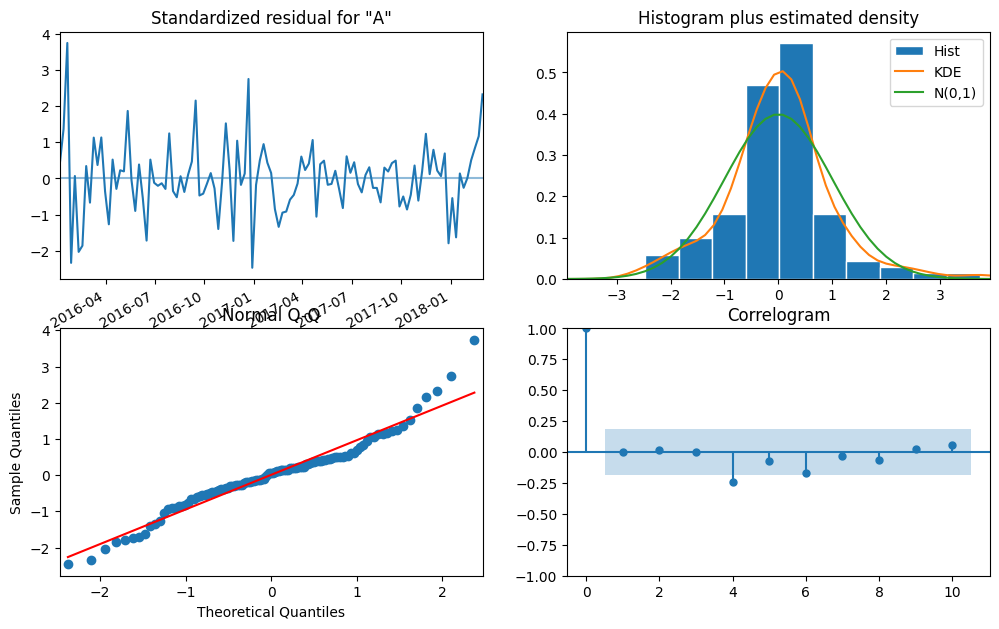

In [22]:
# Строим диагностические графики для стандартизированных остатков одной эндогенной переменной
forecaster._fitted_forecaster.plot_diagnostics(figsize=(12,8));

На графиках выше мы видим:

верхний левый график: остаточные ошибки колеблются около нулевого среднего, дисперсию можно считать равномерной.
верхний правый график: остаток имеет распределение, похожее на нормальное распределение, с небольшими "хвостами".
нижний левый график: автокорреляционная функция не показывает значительных (статистически значимых) отличий от нормального распределения.
нижний правый график: график Q-Q показывает отклонения от нормального распределения.

sMAPE = 0.211


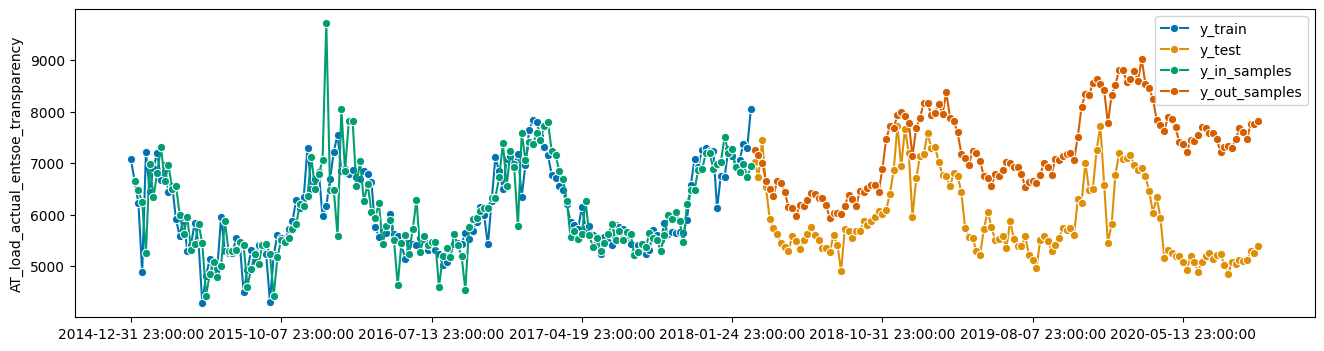

In [23]:
# Предсказание значений ряда для тренировочной и тестовой выборок
fhin = ForecastingHorizon(y_train.index[1:], is_relative=False)
y_in_samples = forecaster.predict(fhin)

fhout = ForecastingHorizon(y_test.index, is_relative=False)
y_out = forecaster.predict(fhout)

plot_series(y_train, y_test, y_in_samples, y_out, labels=["y_train", "y_test", "y_in_samples", "y_out_samples"])

print(f'sMAPE = {smape(y_out.values, y_test.values):.3f}')

In [25]:
# Делаем прогнозы вне выборки на y_test.size интервалов прогнозирования
forecast_res = forecaster._fitted_forecaster.get_forecast(y_test.size, alpha=0.01, dynamic=False)  # 95% conf

# Доверительный интервал для предсказанных значений ряда
forecast_res.conf_int()


/home/slon/.asdf/installs/python/3.10.7/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


,lower AT_load_actual_entsoe_transparency,upper AT_load_actual_entsoe_transparency
2018-03-07 23:00:00,6324.043105,8190.469136
2018-03-14 23:00:00,6157.503261,8174.843089
2018-03-21 23:00:00,5965.910896,8048.239086
2018-03-28 23:00:00,5561.489669,7747.420375
2018-04-04 23:00:00,5296.446965,7704.023404
...,...,...
2020-09-02 23:00:00,674.103996,14522.064252
2020-09-09 23:00:00,487.521864,14435.054751
2020-09-16 23:00:00,735.095747,14781.498119
2020-09-23 23:00:00,678.304640,14822.885160


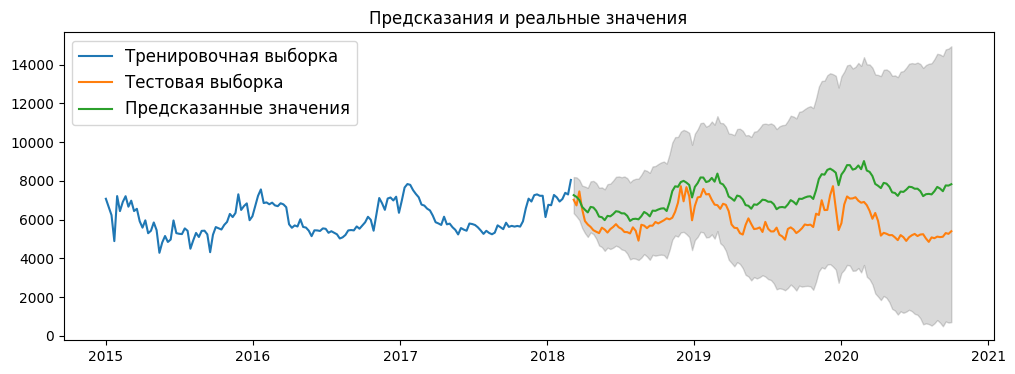

In [28]:
# Для предсказания используем среднее от границ доверительного интервала
forecast = forecast_res.predicted_mean

# Конвертируем в pandas DataFrame
fc_series = pd.Series(forecast.values, index=y_test.index)

lower_series = pd.Series(forecast_res.conf_int()['lower AT_load_actual_entsoe_transparency'], index=y_test.index)
upper_series = pd.Series(forecast_res.conf_int()['upper AT_load_actual_entsoe_transparency'], index=y_test.index)

# Покажем предсказанные значения и доверительный интервал серым цветом
plt.figure(figsize=(12,4), dpi=100)

plt.plot(y_train, label='Тренировочная выборка')
plt.plot(y_test,  label='Тестовая выборка')
plt.plot(fc_series, label='Предсказанные значения')

plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', 
                 alpha=0.15)

plt.title('Предсказания и реальные значения')
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [30]:
# Попробуем найти лучшие параметры (order, seasonal_order) для модели
model = AutoARIMA(start_p=1,       # начальный порядок AR
                  d=1,             # Порядок производной
                  start_q=0,       # начальный порядок MA
                  max_p=3,         # конечный порядок AR
                  max_q=3,         # конечный порядок MA                 
                  seasonal=True,   # Использовать SARIMA  
                  start_P=0,       # начальный порядок SAR
                  start_Q=0,       # начальный порядок SMA                 
                  D=1,             # Порядок сезонной производной
                  sp=52,           # Период сезонности
                  max_order = 4,   # Максимальный порядок p+q+P+Q 
                  trace = True,    # отчет инлайн
                  stepwise = True, # метод ускоренного выбора параметров.
                  n_jobs = 1,      # для stepwise парралелизм не доступен.
                  error_action='ignore',  
                  suppress_warnings=True)


In [31]:
# Запускаем поиск наилучших параметров
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(1,1,0)(0,1,0)[52] intercept   : AIC=1753.522, Time=0.24 sec
 ARIMA(0,1,0)(0,1,0)[52] intercept   : AIC=1767.774, Time=0.69 sec
 ARIMA(1,1,0)(1,1,0)[52] intercept   : AIC=1743.807, Time=5.23 sec
 ARIMA(0,1,1)(0,1,1)[52] intercept   : AIC=inf, Time=7.90 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1765.899, Time=0.73 sec
 ARIMA(1,1,0)(2,1,0)[52] intercept   : AIC=1744.607, Time=34.63 sec
 ARIMA(1,1,0)(1,1,1)[52] intercept   : AIC=1744.435, Time=16.09 sec
 ARIMA(1,1,0)(0,1,1)[52] intercept   : AIC=1742.474, Time=7.58 sec
 ARIMA(1,1,0)(0,1,2)[52] intercept   : AIC=1744.441, Time=38.90 sec
 ARIMA(1,1,0)(1,1,2)[52] intercept   : AIC=1746.441, Time=73.27 sec
 ARIMA(0,1,0)(0,1,1)[52] intercept   : AIC=1756.522, Time=82.11 sec
 ARIMA(2,1,0)(0,1,1)[52] intercept   : AIC=1731.399, Time=12.02 sec
 ARIMA(2,1,0)(0,1,0)[52] intercept   : AIC=1741.729, Time=0.48 sec
 ARIMA(2,1,0)(1,1,1)[52] intercept   : AIC=1733.387, Time=19.08 sec
 ARIMA(2,1,0)(0,1

AutoARIMA(D=1, d=1, error_action='ignore', max_order=4, max_p=3, max_q=3, sp=52,
          start_P=0, start_Q=0, start_p=1, start_q=0, suppress_warnings=True,
          trace=True)

In [ ]:
# Лучшая модель найдена, это ARIMA с параметрами order = (0,1,2), seasonal_order=(0,1,1)

In [32]:
# Используя лучшую ARIMA модель пробуем предсказания:
fhin = ForecastingHorizon(y_train.index[1:], is_relative=False)
y_in_samples = model.predict(fhin)

fhout = ForecastingHorizon(y_test.index, is_relative=False)
y_out = model.predict(fhout)

print(f'{y_in_samples.shape=}, {y_out.shape=}')


y_in_samples.shape=(165,), y_out.shape=(135,)


sMAPE = 0.081


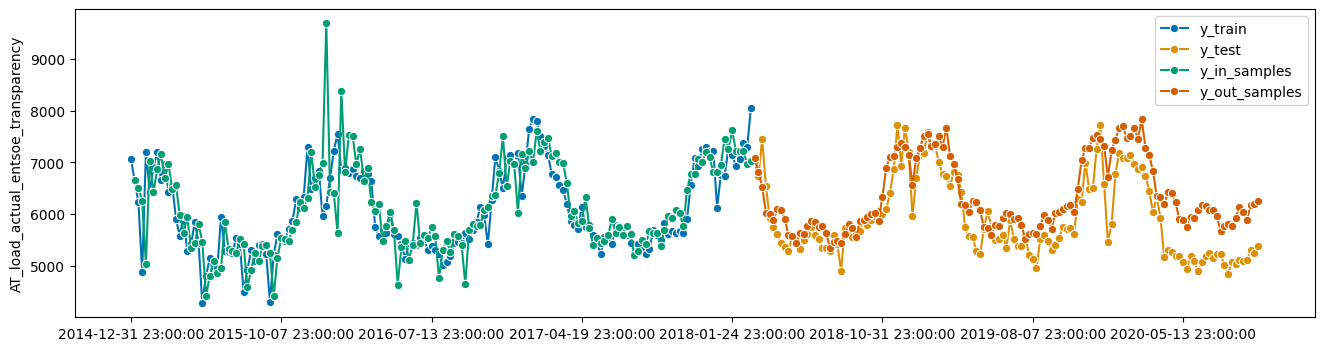

In [33]:
plot_series(y_train, y_test, y_in_samples, y_out, labels=["y_train", "y_test", "y_in_samples", "y_out_samples"])

print(f'sMAPE = {smape(y_out.values, y_test.values):.3f}')

In [ ]:
  # Существенно лучше!
  # Это видно и по стандартной ошибке (0.081) и по графику

sMAPE = 0.048


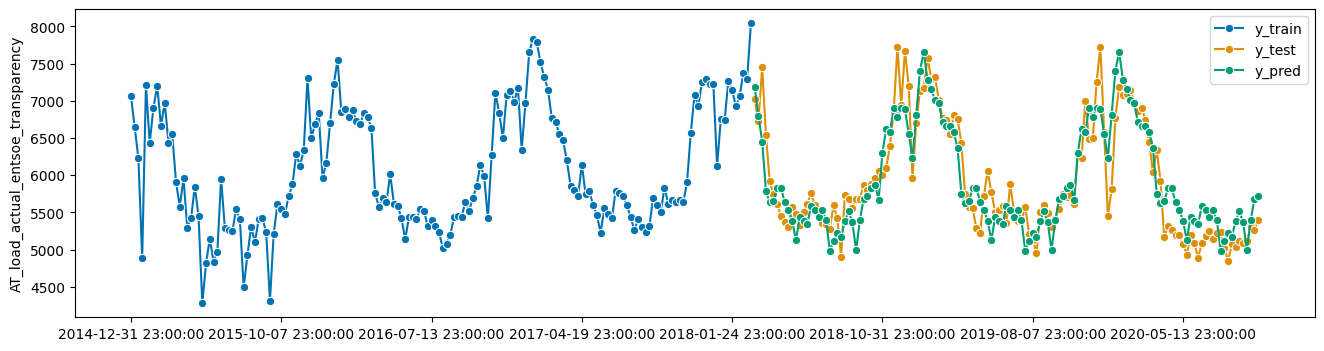

In [34]:
# То же самое с предварительным удалением сезонности данных.
# Best model:  ARIMA(0,1,2)(0,1,1)[52]
forecaster = TransformedTargetForecaster(
    [
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=52)),
        ("forecast", ARIMA( order=(2, 0, 0), seasonal_order=(0, 0, 0, 0),  )),
        # ("forecast", ARIMA( order=(0, 1, 2), seasonal_order=(0, 1, 1),  )),
    ]
)

forecaster.fit(y_train)

fh = ForecastingHorizon(y_test.index, is_relative=False)

y_pred = forecaster.predict(fh)

plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')

In [35]:
# Ещё лучше!


/home/slon/.asdf/installs/python/3.10.7/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
18:01:45 - cmdstanpy - INFO - Chain [1] start processing
18:01:45 - cmdstanpy - INFO - Chain [1] done processing


sMAPE = 0.066


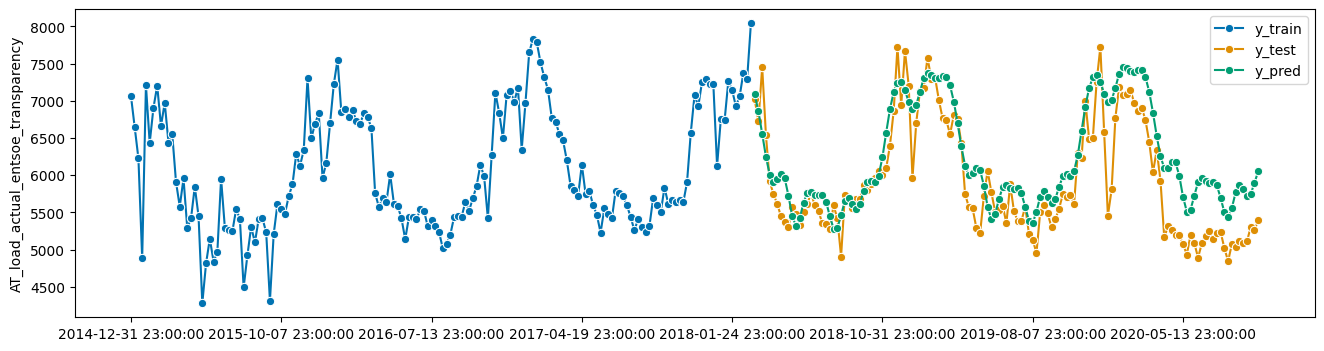

In [36]:
# Попробуем Предсказание с использованием Facebook Prophet
forecaster = Prophet(freq='7d',
                     seasonality_mode='additive',
                     add_country_holidays={'country_name': 'Germany'},
                     yearly_seasonality=True)

forecaster.fit(y_train)
fh = ForecastingHorizon(y_test.index, is_relative=False)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=['y_train', 'y_test', 'y_pred'])
print(f'sMAPE = {smape(y_pred.values, y_test.values):.3f}')